# Semibatch reactor simulation

This example is for the following set of elementary reactions:

1) $A+2B\rightarrow C$

2) $2A+3C\rightarrow D$

Reactant A is added to $V_0=1000dm^3$ of initially pure B ($C_{B0}=0.2 mol/dm^3$) at a flow rate of $v_{feed}=10 dm^3/min$ with a concentration of $C_{A,feed}=0.3 mol/dm^3$. The total volume of the tank is $2000dm^3$. The liquid density is approximately constant at all times. The following design equations govern the system:

$$\frac{dV}{dt}=v_{feed}$$

$$\frac{dN_A}{dt}=r_A\cdot V + v_{feed}\cdot C_{A,feed}$$

$$\frac{dN_B}{dt}=r_B\cdot V$$

$$\frac{dN_C}{dt}=r_C\cdot V$$

$$\frac{dN_D}{dt}=r_D\cdot V$$

We could instead work in terms of $\xi_i$ where:

$$\frac{d\xi_1}{dt}=r_1\cdot V$$

$$\frac{d\xi_2}{dt}=r_2\cdot V$$

These will be performed separately below.

Mode = batch 



C:\Users\neaga\anaconda3\lib\site-packages\ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in true_divide
C:\Users\neaga\anaconda3\lib\site-packages\ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide


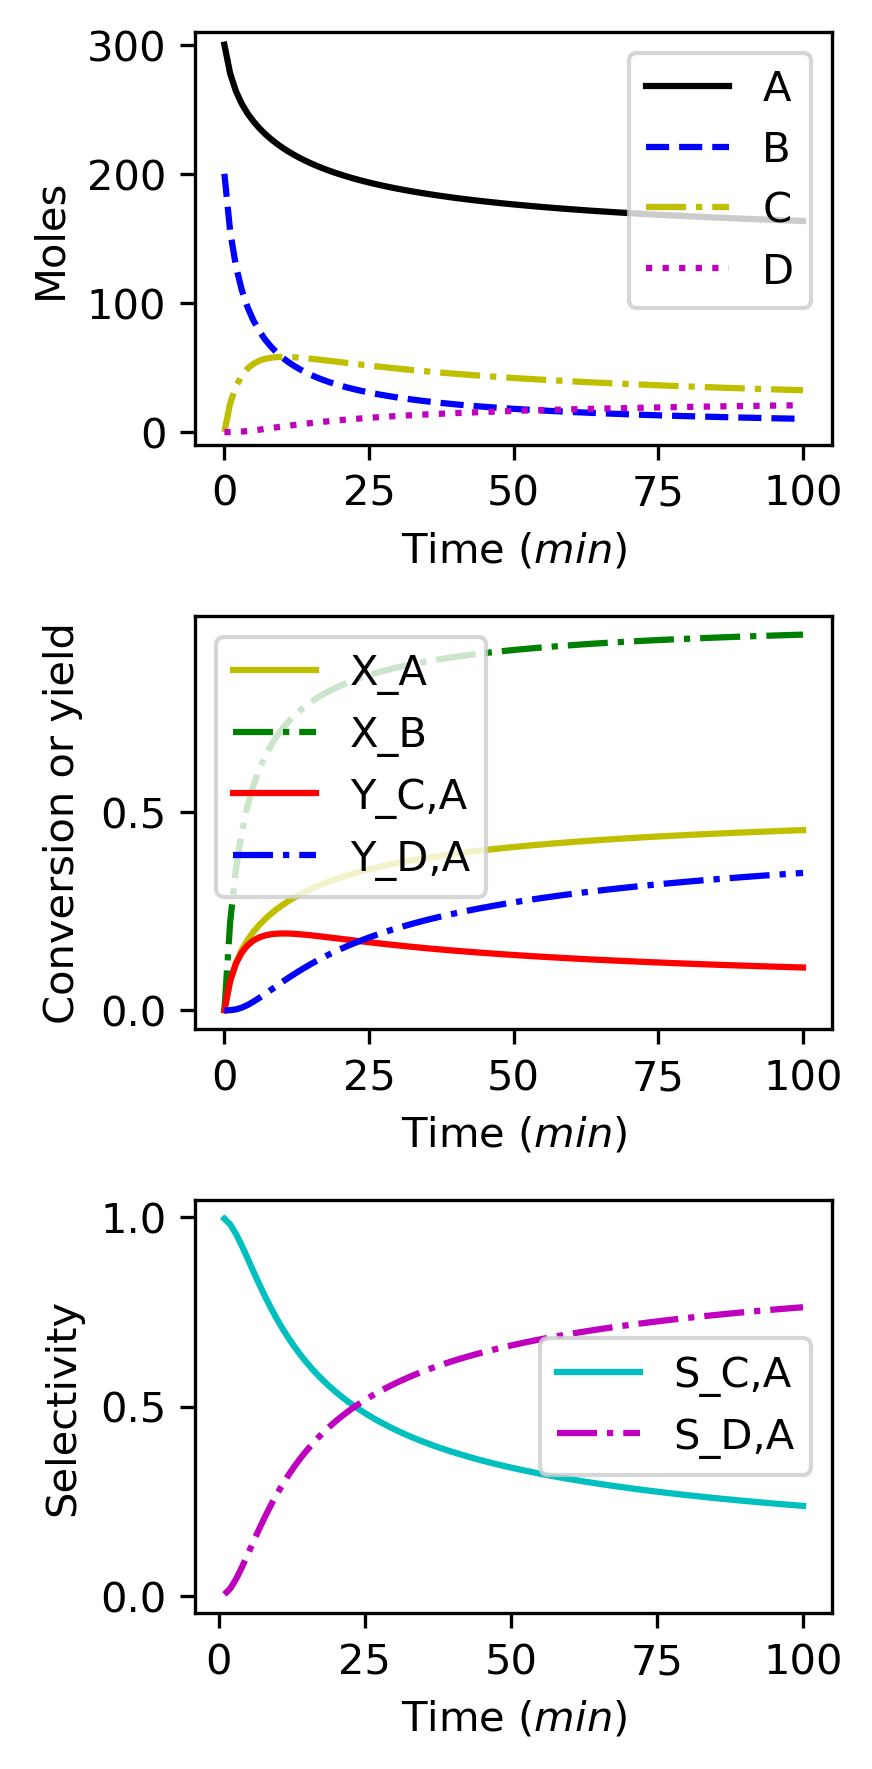

In [1]:
###### 1. Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

###### 2. Specify known values

mode = 'batch' # semi-batch or batch

if mode == 'semibatch':

    print('Mode = semibatch \n')
    ### Initial conditions of tank
    C_A0 = 0       # mol/dm^3
    C_B0 = 0.2     # mol/dm^3
    C_C0 = 0       # mol/dm^3
    C_D0 = 0       # mol/dm^3
    V0   = 1000      # dm^3

    ### Specify inlet conditions
    C_Afeed = 0.3  # mol/dm^3
    v_feed  = 10    # dm^3/min

elif mode == 'batch':

    print('Mode = batch \n')
    ### Batch alterations
    C_A0   = 0.3*10*100/2000   # mol/dm^3
    C_B0   = 0.2*1000/2000     # mol/dm^3
    C_C0   = 0                 # mol/dm^3
    C_D0   = 0                 # mol/dm^3
    V0     = 2000              # dm^3
    
    ### Specify inlet conditions
    C_Afeed = 0  # mol/dm^3
    v_feed  = 0  # dm^3/min

else:

    print('Reaction mode does not exist! \n')
        
### Specify kinetic parameters
k1 = 10       # dm^6 / mol^2 min
k2 = 1000     # dm^12 / mol^4 min

###### 3. Initial conditions and integration span
N_A0 = C_A0 * V0
N_B0 = C_B0 * V0
N_C0 = C_C0 * V0
N_D0 = C_D0 * V0
U0 = [N_A0 , N_B0 , N_C0 , N_D0 , V0]
tlim = (0,100)
tlist = np.linspace(tlim[0],tlim[1],num=101) # Not essential

###### 4. Differential equations
def diff(t,U):
    
    ### Assign inputs to concentrations
    N_A = U[0]
    N_B = U[1]
    N_C = U[2]
    N_D = U[3]
    V   = U[4]
    
    ### Calculate concentrations
    C_A = N_A / V
    C_B = N_B / V
    C_C = N_C / V
    C_D = N_D / V
    
    ### Define reaction rates
    r1 = k1 * C_A * C_B**2
    r2 = k2 * C_A**2 * C_C**3
    
    ### Define production rates of individual species
    R_A =   -r1 - 2*r2
    R_B = -2*r1
    R_C =    r1 - 3*r2
    R_D =           r2
    
    # Define differential equations
    dN_A = R_A*V + v_feed * C_Afeed
    dN_B = R_B*V
    dN_C = R_C*V
    dN_D = R_D*V
    dV   = v_feed
    
    ### Fit equations into array
    dU=np.zeros(len(U))
    dU[0] = dN_A
    dU[1] = dN_B
    dU[2] = dN_C
    dU[3] = dN_D
    dU[4] = dV
    
    ### Reorganize list to fit required dimensions 
    dU = np.array(dU).tolist()
    
    return dU

###### 5. Integrate
solution = solve_ivp(diff,tlim,U0,t_eval=tlist)

###### 6. Extract and use data

U = solution.y.T #.T is transpose to make vertical arrays; not essential
t = solution.t

N_A = U[:,0]
N_B = U[:,1]
N_C = U[:,2]
N_D = U[:,3]
V   = U[:,4]

### Calculate concentrations
C_A = N_A / V
C_B = N_B / V
C_C = N_C / V
C_D = N_D / V

### Conversion, selectivity, and yield calculations
N_A0_adj = N_A0+C_Afeed*v_feed*t[-1]
N_A_adj = N_A+C_Afeed*v_feed*(t[-1]-t)

X_A = (N_A0_adj-N_A_adj)/(N_A0_adj)
X_B = (N_B0-N_B)/N_B0
Y_C_A = N_C/N_A0_adj
Y_D_A = N_D*5/N_A0_adj
S_C_A = N_C/(N_A0_adj-N_A_adj)
S_D_A = N_D*5/(N_A0_adj-N_A_adj)

### Plotting
fig = plt.figure(figsize=(3,6),dpi=300)
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

# Batch moles
ax1.plot(t,N_A,'-k')
ax1.plot(t,N_B,'--b')
ax1.plot(t,N_C,'-.y')
ax1.plot(t,N_D,':m')
ax1.legend(['A','B','C','D'])
ax1.set_xlabel('Time ($min$)')
ax1.set_ylabel('Moles')
ax1.set_ylim([-10,310])

# Conversions and yields
ax2.plot(t,X_A,'y')
ax2.plot(t,X_B,'-.g')
ax2.plot(t,Y_C_A,'r')
ax2.plot(t,Y_D_A,'-.b')
ax2.legend(['X_A','X_B','Y_C,A','Y_D,A'])
ax2.set_xlabel('Time ($min$)')
ax2.set_ylabel('Conversion or yield')

# Selectivity
ax3.plot(t,S_C_A,'c')
ax3.plot(t,S_D_A,'-.m')
ax3.legend(['S_C,A','S_D,A'])
ax3.set_xlabel('Time ($min$)')
ax3.set_ylabel('Selectivity')

fig.tight_layout()
plt.show()

In [6]:
## Assign output to specific scenario

# Store values for different scenarios
if mode == 'semibatch':
    N_A_semibatch = N_A
    N_B_semibatch = N_B
    N_C_semibatch = N_C
    N_D_semibatch = N_D
    X_A_semibatch = X_A
    X_B_semibatch = X_B
    S_C_A_semibatch = S_C_A
    Y_C_A_semibatch = Y_C_A

if mode == 'batch':
    N_A_batch = N_A
    N_B_batch = N_B
    N_C_batch = N_C
    N_D_batch = N_D
    X_A_batch = X_A
    X_B_batch = X_B
    S_C_A_batch = S_C_A
    Y_C_A_batch = Y_C_A

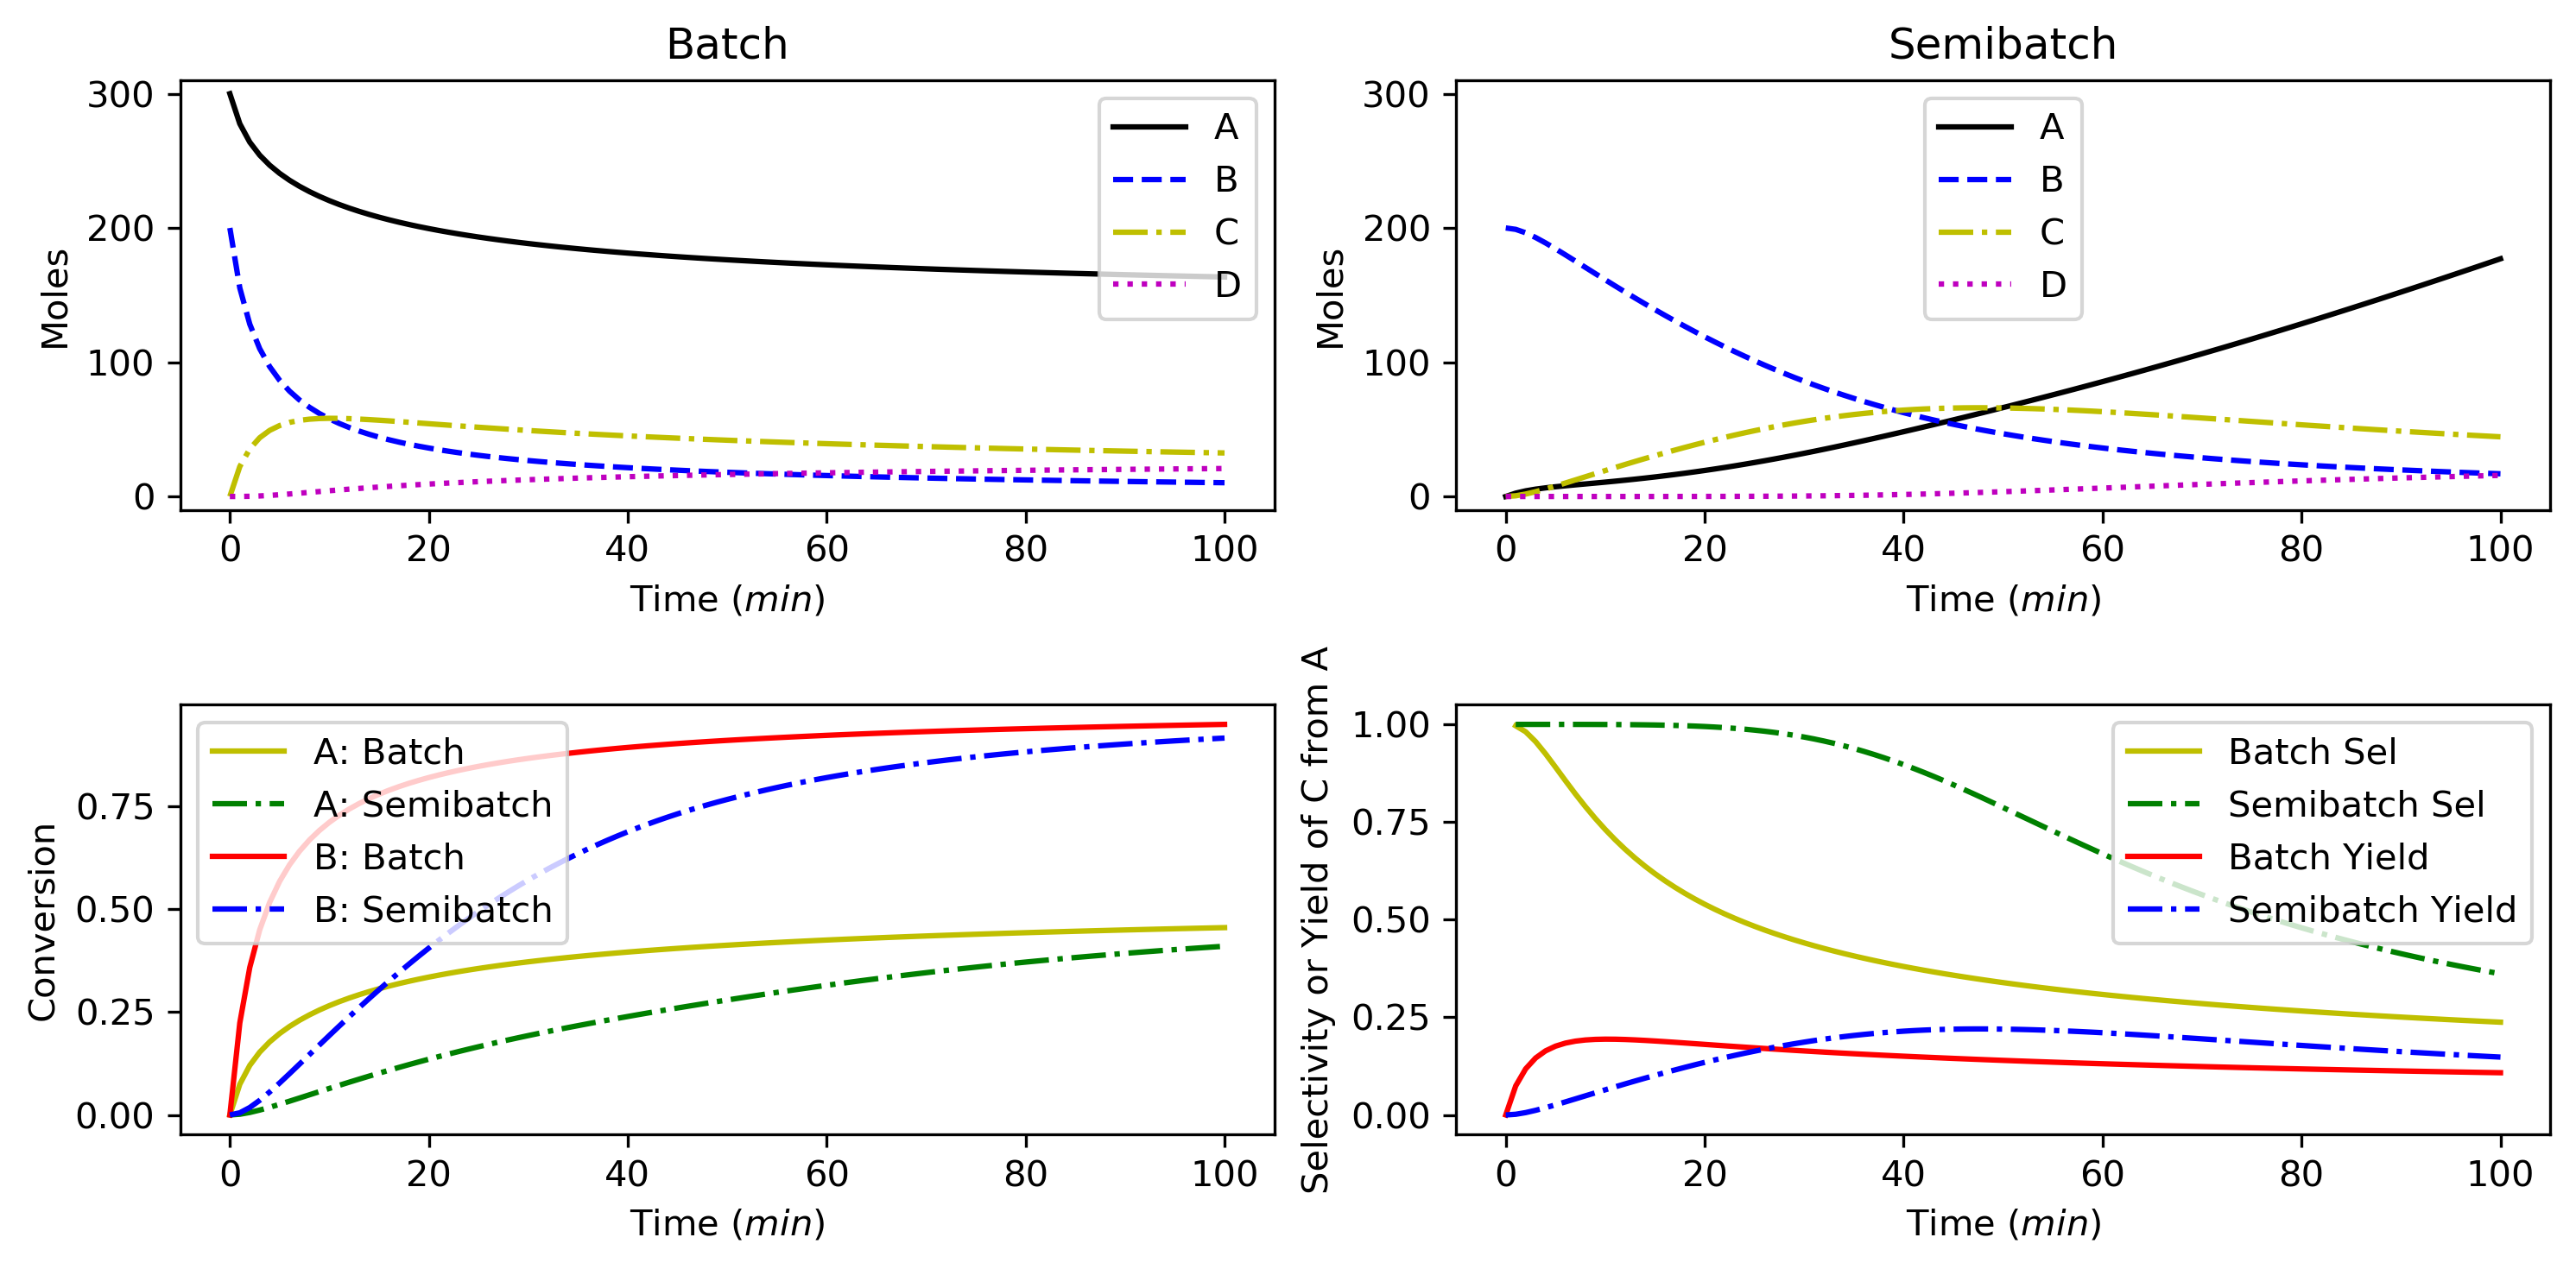

In [7]:
# Plotting
fig = plt.figure(figsize=(10,5),dpi=300)
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

# Batch moles
ax1.plot(t,N_A_batch,'-k')
ax1.plot(t,N_B_batch,'--b')
ax1.plot(t,N_C_batch,'-.y')
ax1.plot(t,N_D_batch,':m')
ax1.legend(['A','B','C','D'])
ax1.set_xlabel('Time ($min$)')
ax1.set_ylabel('Moles')
ax1.set_ylim([-10,310])
ax1.set_title('Batch')

# Semibatch moles
ax2.plot(t,N_A_semibatch,'-k')
ax2.plot(t,N_B_semibatch,'--b')
ax2.plot(t,N_C_semibatch,'-.y')
ax2.plot(t,N_D_semibatch,':m')
ax2.legend(['A','B','C','D'])
ax2.set_xlabel('Time ($min$)')
ax2.set_ylabel('Moles')
ax2.set_ylim([-10,310])
ax2.set_title('Semibatch')

# Conversion of B
ax3.plot(t,X_A_batch,'y')
ax3.plot(t,X_A_semibatch,'-.g')
ax3.plot(t,X_B_batch,'r')
ax3.plot(t,X_B_semibatch,'-.b')
ax3.legend(['A: Batch','A: Semibatch','B: Batch','B: Semibatch'])
ax3.set_xlabel('Time ($min$)')
ax3.set_ylabel('Conversion')

# Selectivity or Yield of C
ax4.plot(t,S_C_A_batch,'y')
ax4.plot(t,S_C_A_semibatch,'-.g')
ax4.plot(t,Y_C_A_batch,'r')
ax4.plot(t,Y_C_A_semibatch,'-.b')
ax4.legend(['Batch Sel','Semibatch Sel','Batch Yield','Semibatch Yield'])
ax4.set_xlabel('Time ($min$)')
ax4.set_ylabel('Selectivity or Yield of C from A')

fig.tight_layout()
plt.show()

fig.savefig('figure.png')

## Staged profile

C:\Users\neaga\anaconda3\lib\site-packages\ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
C:\Users\neaga\anaconda3\lib\site-packages\ipykernel_launcher.py:145: RuntimeWarning: invalid value encountered in true_divide


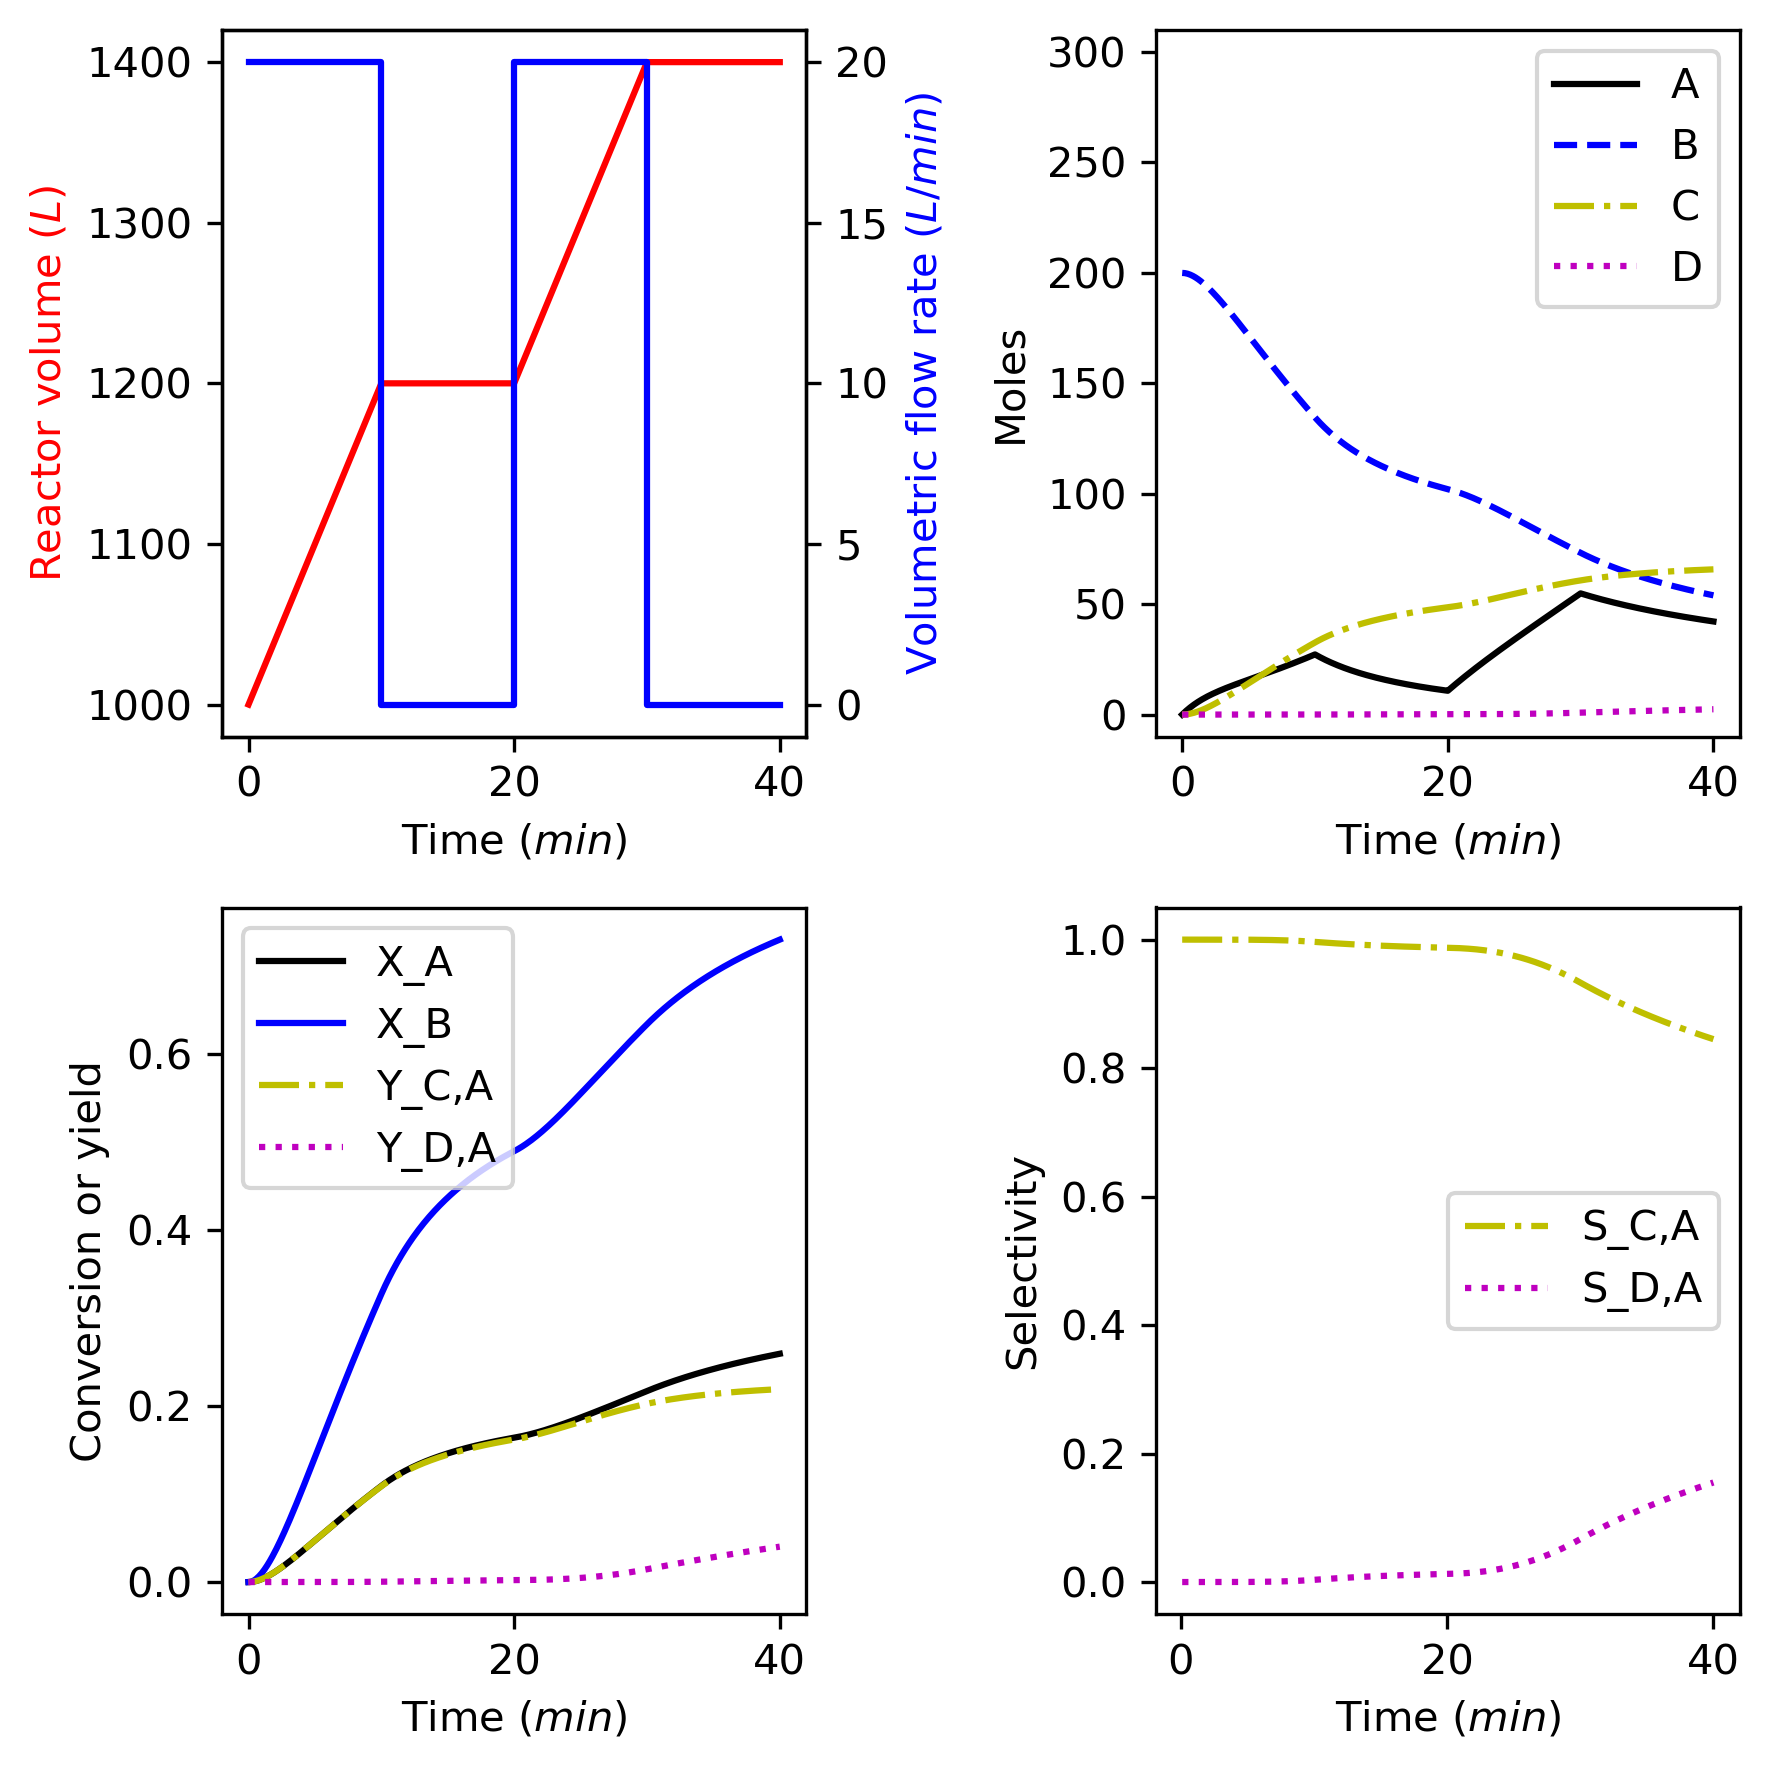

In [2]:
###### 1. Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

###### 2. Specify known values

### Initial conditions of tank
C_A0 = 0       # mol/dm^3
C_B0 = 0.2     # mol/dm^3
C_C0 = 0       # mol/dm^3
C_D0 = 0       # mol/dm^3
V0   = 1000      # dm^3

### Specify feed concentration
C_Afeed = 0.3  # mol/dm^3

### Specify kinetic parameters
k1 = 10       # dm^6 / mol^2 min
k2 = 1000     # dm^12 / mol^4 min

###### 3. Cycle profile

### Cycle schedule
v_profile = [20,0,20,0]    # flow rate at each point
cycle_half_length = [10,10,10,10] # duration of each point

#cycle_half_length = 10*np.ones(len(v_profile))

### Specify initial conditions of first dosage

### First half cycle
tlim=(0,cycle_half_length[0])                  
tlist = np.linspace(tlim[0],tlim[1],num=101)
v_feed = v_profile[0]

N_A0 = C_A0 * V0
N_B0 = C_B0 * V0
N_C0 = C_C0 * V0
N_D0 = C_D0 * V0
U0 = [N_A0 , N_B0 , N_C0 , N_D0 , V0]

###### 4. Differential equations
def diff_1(t,U):
    
    ### Assign inputs to concentrations
    N_A = U[0]
    N_B = U[1]
    N_C = U[2]
    N_D = U[3]
    V   = U[4]
    
    ### Calculate concentrations
    C_A = N_A / V
    C_B = N_B / V
    C_C = N_C / V
    C_D = N_D / V
    
    ### Define reaction rates
    r1 = k1 * C_A * C_B**2
    r2 = k2 * C_A**2 * C_C**3
    
    ### Define production rates of individual species
    R_A =   -r1 - 2*r2
    R_B = -2*r1
    R_C =    r1 - 3*r2
    R_D =           r2
    
    # Define differential equations
    dC_A = R_A*V + v_feed * C_Afeed
    dC_B = R_B*V
    dC_C = R_C*V
    dC_D = R_D*V
    dV   = v_feed
    
    ### Fit equations into array
    dU=np.zeros(len(U))
    dU[0] = dC_A
    dU[1] = dC_B
    dU[2] = dC_C
    dU[3] = dC_D
    dU[4] = dV
    
    ### Reorganize list to fit required dimensions 
    dU = np.array(dU).tolist()
    
    return dU

###### 5. Perform piecewise integrations

### Generate first dosage profile
solution = solve_ivp(diff_1,tlim,U0,t_eval=tlist) 
t = solution.t                                  
U = solution.y.T         

### Initialize "overall" arrays which track values throughout treatment
N_A_overall = U[:,0]
N_B_overall = U[:,1]
N_C_overall = U[:,2]
N_D_overall = U[:,3]
V_overall   = U[:,4]

t_overall = t

### Conduct individual doses, update "overall" array

for i,val in enumerate(v_profile):
    
    if i > 0:
        
        ### Define initial dosage concentration based on prior dosage and new number of doses
        N_A0_cycle = N_A_overall[-1]
        N_B0_cycle = N_B_overall[-1]
        N_C0_cycle = N_C_overall[-1]
        N_D0_cycle = N_D_overall[-1]
        V0_cycle  = V_overall[-1]

        ### Generate dosage profile
        tlim=(0,cycle_half_length[i])
        tlist = np.linspace(tlim[0],tlim[1],num=101)
        U0 = [N_A0_cycle , N_B0_cycle , N_C0_cycle , N_D0_cycle , V0_cycle]
        v_feed = v_profile[i]
        
        solution = solve_ivp(diff_1,tlim,U0,t_eval=tlist)
        U = solution.y.T
        t = solution.t
        
        ### Add outputs to "overall" arrays
        N_A_overall = np.concatenate([N_A_overall,U[:,0]])
        N_B_overall = np.concatenate([N_B_overall,U[:,1]])
        N_C_overall = np.concatenate([N_C_overall,U[:,2]])
        N_D_overall = np.concatenate([N_D_overall,U[:,3]])
        V_overall   = np.concatenate([V_overall,U[:,4]])
        t_overall   = np.concatenate([t_overall,t+t_overall[-1]])

### Conversion, selectivity, and yield calculations
N_A0_adj = N_A0+C_Afeed*1000
N_A_adj = N_A_overall+C_Afeed*(2000-V_overall)

X_A = (N_A0_adj-N_A_adj)/(N_A0_adj)
X_B = (N_B0-N_B_overall)/N_B0
Y_C_A = N_C_overall/N_A0_adj
Y_D_A = N_D_overall*5/N_A0_adj
S_C_A = N_C_overall/(N_A0_adj-N_A_adj)
S_D_A = N_D_overall*5/(N_A0_adj-N_A_adj)      
        
### Plotting
fig = plt.figure(figsize=(6,6),dpi=300)
ax1 = plt.subplot(222)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)
ax4 = plt.subplot(221)

# Batch moles
ax1.plot(t_overall,N_A_overall,'-k')
ax1.plot(t_overall,N_B_overall,'--b')
ax1.plot(t_overall,N_C_overall,'-.y')
ax1.plot(t_overall,N_D_overall,':m')
ax1.legend(['A','B','C','D'])
ax1.set_xlabel('Time ($min$)')
ax1.set_ylabel('Moles')
ax1.set_ylim([-10,310])

# Conversions and yields
#ax2.plot(t_overall,V_overall,'y')
ax2.plot(t_overall,X_A,'k')
ax2.plot(t_overall,X_B,'-b')
ax2.plot(t_overall,Y_C_A,'-.y')
ax2.plot(t_overall,Y_D_A,':m')
ax2.legend(['X_A','X_B','Y_C,A','Y_D,A'])
ax2.set_xlabel('Time ($min$)')
ax2.set_ylabel('Conversion or yield')

# Selectivity
ax3.plot(t_overall,S_C_A,'-.y')
ax3.plot(t_overall,S_D_A,':m')
ax3.legend(['S_C,A','S_D,A'])
ax3.set_xlabel('Time ($min$)')
ax3.set_ylabel('Selectivity')

# Create lists containing volumetric flow rate vs time for plotting
v_overall_cycle = []
t_overall_cycle = [0]
for i,val in enumerate(v_profile):
    v_overall_cycle.append(v_profile[i])
    v_overall_cycle.append(v_profile[i])
    
    t_overall_cycle.append(cycle_half_length[i]+t_overall_cycle[-1])
    t_overall_cycle.append(cycle_half_length[i]+t_overall_cycle[-2])
t_overall_cycle = t_overall_cycle[:-1]                   

# Volume and volumetric flow rate
ax4.plot(t_overall,V_overall,'r')
ax4.set_xlabel('Time ($min$)')
ax4.set_ylabel('Reactor volume ($L$)',color='red')

ax5=ax4.twinx()
ax5.plot(t_overall_cycle,v_overall_cycle,'b')
ax5.set_ylabel('Volumetric flow rate ($L/min$)',color='blue')

fig.savefig('figure.png')

fig.tight_layout()
plt.show()